In [52]:
import pandas as pd
from graphdatascience import GraphDataScience
from getpass import getpass
import kmedoids
import numpy as np
from matplotlib import pyplot as plt

# Load data
This notebook uses a dataset of Amtrak rail lines in the US. Download the tar file with the database backup from Github. Then [import the tar file to an AuraDS instance](https://neo4j.com/docs/aura/aurads/importing-data/import-db/) or unzip the file and [import the neo4j.dump file into a Neo4j Desktop database](https://neo4j.com/docs/desktop-manual/current/operations/create-from-dump/) that has the GDS plugin enabled.

# Connect to Neo4j

In [2]:
neo4j_pwd = getpass("Neo4j password")

Neo4j password ········


The connection URI for your Neo4j instance is available in the AuraDS console or by copying the Bolt port from the details panel for for your DBMS in Neo4j Desktop.

In [ ]:
connection_uri = "neo4j+s://79412e05.databases.neo4j.io"

In [5]:
gds = GraphDataScience(connection_uri, auth=("neo4j", neo4j_pwd))

In [158]:
gds.set_database("neo4j")

# Functions for k-medoid analysis

In [156]:
def find_giant_component(projection, wccProperty, subgraph_name):
    # Mutate the graph with wcc id so we can use it for filtering
    gds.wcc.mutate(projection, mutateProperty=wccProperty)
    # Write the wcc id to the graph so we can use it for filtering in Bloom
    gds.graph.nodeProperties.write(projection, wccProperty)
    # Get the id of the giant component
    wcc_df = gds.graph.nodeProperties.stream(projection, wccProperty)
    biggest_component_id = wcc_df['propertyValue'].value_counts().idxmax()
    # Filter the projection to the giant component
    subgraph, result = gds.graph.filter(subgraph_name,
                                projection,
                                f"n.{wccProperty} = {biggest_component_id}",
                                "*")
    return subgraph, result

In [90]:
def get_distance_array(projection, 
                       relationshipWeightProperty=None, 
                       concurrency=4):
    all_pairs = gds.allShortestPaths.stream(projection, 
                                            relationshipWeightProperty = relationshipWeightProperty, 
                                            concurrency=concurrency)
    distance_df = all_pairs.pivot(index='sourceNodeId', columns='targetNodeId', values='distance')
    distance_array = distance_df.fillna(0).values
    return distance_array, distance_df.columns

In [100]:
def test_values_of_k(k_list, distance_array):
    result_df = pd.DataFrame(columns=['k', 'loss', 'silhouette'])
    for k in k_list:
        km = kmedoids.KMedoids(k, method="fasterpam")
        c = km.fit(distance_array)
        silhouette, _ = kmedoids.medoid_silhouette(distance_array, 
                                                   c.medoid_indices_, 
                                                   False)
        result_df.loc[len(result_df.index)] = [k, c.inertia_, silhouette]
    result_df.plot.scatter(x='k', y='silhouette')
    return result_df

In [107]:
def write_kmedoid(distance_array,
                  array_index,
                  k,
                  medoid_property_name,
                  cluster_property_name):
    km = kmedoids.KMedoids(k, method='fasterpam')
    c = km.fit(distance_array)
    medoid_ids = [array_index[i] for i in c.medoid_indices_]
    gds.run_cypher(f"""
                    UNWIND $medoidIds as medoidId
                    WITH gds.util.asNode(medoidId) AS medoid
                    SET medoid.{medoid_property_name} = True""",
                   {"medoidIds": medoid_ids})
    gds.run_cypher(f"""
                    UNWIND range(0, size($labels)-1) AS i
                    WITH $labels[i] AS label, $nodeIds[i] AS nodeId
                    WITH label, gds.util.asNode(nodeId) AS member
                    SET member.{cluster_property_name} = label""",
                   {"labels": c.labels_, "nodeIds": list(array_index)})
    return c.medoid_indices_, c.labels_

In [173]:
def create_silhouette_plot(distance_array, labels, medoid_indices):
    score, samples = kmedoids.medoid_silhouette(distance_array, medoid_indices, True)
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    y_ticks = []
    y_lower = y_upper = 0
    for i,cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = samples[labels ==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
    
        ax.barh(range(y_lower,y_upper),
                   cluster_silhouette_vals,height =1);
        ax.text(-0.03,(y_lower+y_upper)/2,str(i))
        y_lower += len(cluster_silhouette_vals)
       
    # Get the average silhouette score 
    ax.axvline(score,linestyle ='--',
    linewidth =2,color = 'green')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.set_xlabel('Medoid silhouette values')
    ax.set_ylabel('Cluster labels')
    ax.set_title('Medoid silhouette plot')

# Analyze Amtrak network

In [153]:
g_amtrak, result = gds.graph.project("amtrak", 
                                     "Station",
                                     {"CONNECTS_TO":
                                      {"orientation": "UNDIRECTED",
                                       "properties":{"distance":"distance"}
                                      }
                                     }
                                    )

In [165]:
g_amtrak_connected, result = find_giant_component(g_amtrak, 
                                                  "wccId",
                                                  "amtrak_connected")

In [166]:
amtrak_distance_array, amtrak_index = get_distance_array(g_amtrak_connected,
                                                         relationshipWeightProperty="distance",
                                                         concurrency=5)

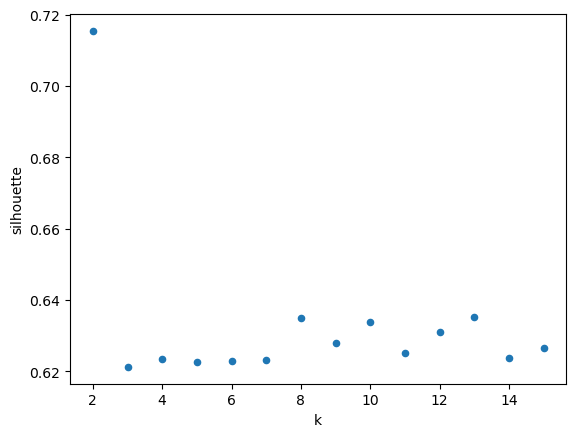

In [167]:
amtrak_result_df = test_values_of_k(range(2,16), amtrak_distance_array)

In [175]:
amtrak_medoids, amtrak_labels = write_kmedoid(amtrak_distance_array, 
                                              amtrak_index, 
                                              8, 
                                              "medoid", 
                                              "partitionId")

Failed to read from defunct connection ResolvedIPv4Address(('34.28.32.244', 7687)) (ResolvedIPv4Address(('34.28.32.244', 7687)))
Unable to retrieve routing information
Unable to connect to the Neo4j DBMS. Trying again...


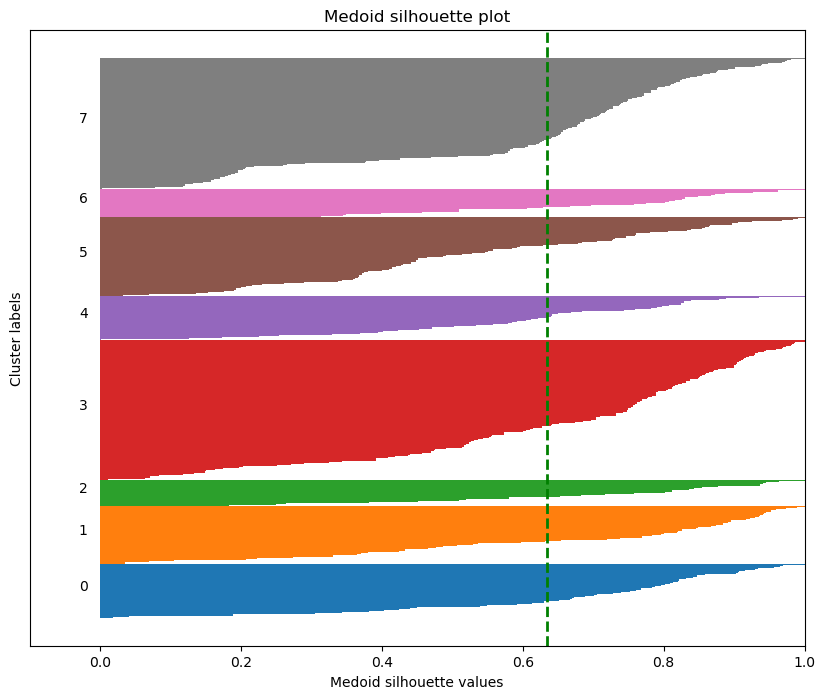

In [176]:
create_silhouette_plot(amtrak_distance_array, amtrak_labels, amtrak_medoids)

# Try on genetic network
## Download data
Data from Cho, Ara and Shin, Junha and Hwang, Sohyun and Kim, Chanyoung and Shim, Hongseok and Kim, Hyojin and Kim, Hanhae and Lee, Insuk (2014). "WormNet v3: a network-assisted hypothesis-generating server for Caenorhabditis elegans." Nucleic acids research, 42(W1), W76-W82.

Hosted by [The Network Data Repository with Interactive Graph Analytics and Visualization](https://networkrepository.com)

In [177]:
import urllib.request
import zipfile

In [178]:
file_name, headers = urllib.request.urlretrieve("https://nrvis.com/download/data/bio/bio-CE-LC.zip", "bio-CE-LC.zip")

In [179]:
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('.')

In [180]:
edge_df = pd.read_csv('bio-CE-LC.edges', sep=' ', header=None)
edge_list = edge_df.values.tolist()

## Send data to Neo4j

In [181]:
gds.run_cypher("""CREATE CONSTRAINT geneId FOR (p:Gene) REQUIRE p.id IS NODE KEY""")

Failed to write data to connection ResolvedIPv4Address(('34.28.32.244', 7687)) (ResolvedIPv4Address(('34.28.32.244', 7687)))
Failed to write data to connection IPv4Address(('79412e05.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.28.32.244', 7687)))


""


In [182]:
gds.run_cypher("""
UNWIND $edgeList AS rel
WITH rel[0] AS id1, rel[1] AS id2 
MERGE (m1:Gene {id:id1})
MERGE (m2:Gene {id:id2})
MERGE (m1)-[:RELATES_TO]->(m2)""",
               {"edgeList": edge_list})

""


## Run k-medoid analysis

In [184]:
g_gene, result = gds.graph.project("genes", "Gene", {"RELATES_TO": {"orientation": "UNDIRECTED"}})

In [187]:
g_gene_connected, result = find_giant_component(g_gene, "wccId", "gene_connected")

In [189]:
gene_distance_array, gene_index = get_distance_array(g_gene_connected,
                                                     concurrency=5)

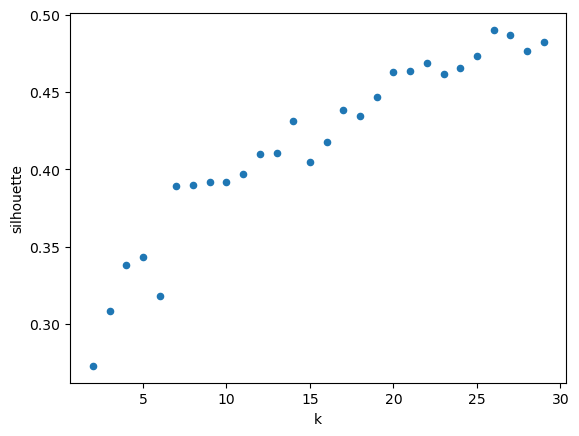

In [190]:
gene_result_df = test_values_of_k(range(2,30), gene_distance_array)

In [192]:
gene_medoids, gene_labels = write_kmedoid(gene_distance_array,
                                          gene_index,
                                          14,
                                          "medoid", 
                                          "partitionId")

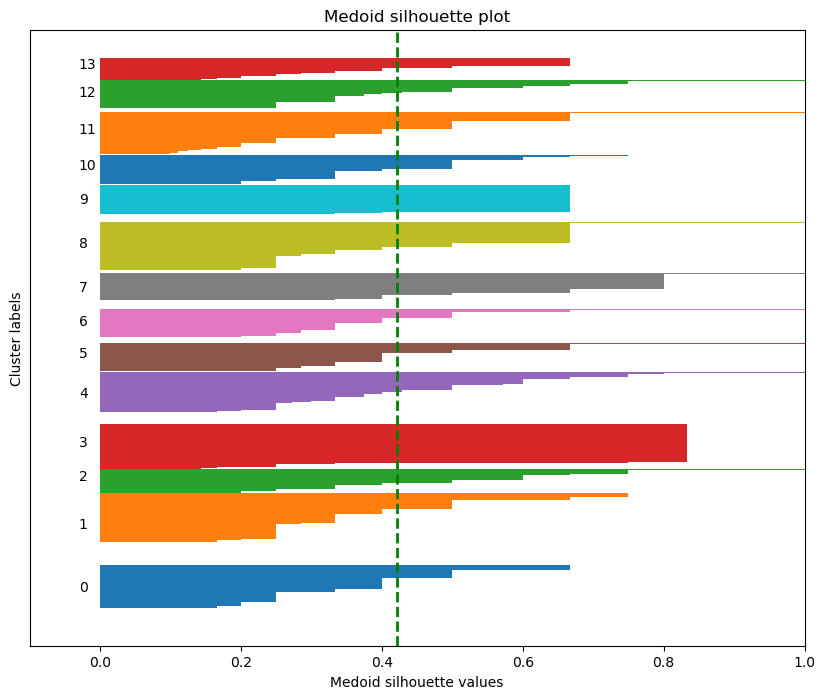

In [193]:
create_silhouette_plot(gene_distance_array, gene_labels, gene_medoids)